In [1]:
#from loguru import logger

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt

from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import forward, BetaMixture
from bmws.data import Dataset
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf, sample_paths
from bmws.sim import sim_admix
rng = np.random.default_rng()

In [2]:

#Load data
def read_data(pop, k_tag=""):

    admixture_proportions=pd.read_csv("data/"+pop+k_tag+"_sample_info.txt", sep="\t")
    admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
    admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

    #merge allele counts 
    counts=pd.read_csv("data/"+pop+"_snp_acs.raw", sep="\t")
    snps=list(counts.columns)[6:]
    data=pd.merge(admixture_proportions, counts, on="IID")

    #Parameters for data matrices
    T=max(data["generation"])+1
    N=max(data["generation"].value_counts().values)
    K=admixture_proportions.shape[1]-7
    datasets=[]
    for snp in snps:
        records = []
        for gen, count in data["generation"].value_counts().items():
            this_data=data[data["generation"]==gen]
            M=this_data.shape[0]
            for i in range(M):
                if not this_data[snp].isna().iloc[i]:
                    rec = {'t': gen}
                    rec['obs'] = (1, int(this_data[snp].values[i] / 2))
                    rec['theta'] = [this_data["k"+str(k+1)].iloc[i] for k in range(K-1)]
                    rec['theta'].append(1 - sum(rec['theta']))
                    records.append(rec)
        
        datasets.append(Dataset.from_records(records))
        
    return datasets, snps

In [9]:
#Run analysis - no longer fails!
def run_analysis(data, alpha=1e4, beta=1e4, gamma=0, em_iterations=8):
    M=100
    Ne=np.full([data.T, data.K], 1e4)
    Ne_fit=Ne
    s = np.zeros([data.T, data.K])
    ab = np.ones([2, data.K]) + 1e-4
    estimate_kwargs={"alpha": alpha, "beta": beta, "gamma": gamma}

#    with jax.debug_nans(True):
#        for i in range(em_iterations):
#            logger.info("EM iteration {}", i)
#            ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
#            logger.info("ab: {}", ab)
#            s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
#            logger.info("s: {}", s)

    for i in range(em_iterations):
        ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
        s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
            
    return s, prior, Ne

In [4]:
#Resampling 
def resample(s, data, Ne, prior, N=10):
    paths=sample_paths(s, Ne, data, prior, N)
    #Now resample observations
    dataset_samples=[]
    s_samples=[]
    for i in range(N):
        t=data.t
        theta=data.theta
        obs=data.obs
        records = []
        Tmax=int(max(t))
        for k in range(obs.shape[0]):
            rec = {'t': int(t[k])}
            rec['obs'] = (int(obs[k][0]),rng.binomial(int(obs[k][0]), float(np.sum(paths[i,:,Tmax-int(t[k])]*data.theta[k]))))
            rec['theta'] = data.theta[k]
            records.append(rec)
        
        dataset_samples.append(Dataset.from_records(records))
        #run inference
        s_s,prior_s,Ne_s = run_analysis(dataset_samples[i], alpha=1e4, beta=1, em_iterations=2)
        s_samples.append(s_s)
    
    s_samples=np.stack([np.transpose(x) for x in s_samples], axis=0)
    
    return s_samples, paths

In [14]:
#Run for rs2072786 SAM 
pop="sam"
datasets, snps=read_data(pop)
snp="rs2072786_C(/G)"
data=datasets[snps.index(snp)]

s,prior,Ne=run_analysis(data, alpha=1e4, beta=1, em_iterations=10)
s_samples, paths=resample(s, data, Ne, prior, N=10)

2024-12-10 17:15:58.279 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[48.37061028, 45.9279184 ],
       [86.2022981 , 65.26572199]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(190.79312915, dtype=float64, weak_type=True), success=False, status=2, iter_num=13, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(62, dtype=int32), num_jac_eval=Array(62, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:18:05.499 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.09958245e-01, -2.14363808e-02],
       [-1.09835209e-01, -2.14285773e-02],
       [-1.09588707e-01, -2.14129899e-02],
       [-1.09219079e-01, -2.13896475e-02],
       [-1.08722155e-01, -2.13585986e-02],
       [-1.08099038e-01, -2.13198945e-02],
       [-1.07348190e-01, -2.12736101e-02],
       [-1.06471321e-01, -2.12198217e-02],
       [-1.05466409e-01, -2.11586301e-02],
       [-1.04335382e-01, -2.10901387e-02],
       [-1.03075865e-01,

2024-12-10 17:18:07.185 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[48.37061028, 45.9279184 ],
       [86.2022981 , 65.26572199]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88001748, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(15, dtype=int32), num_jac_eval=Array(15, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:21:08.942 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10017011e-01, -2.20092859e-02],
       [-1.09895388e-01, -2.20014670e-02],
       [-1.09652000e-01, -2.19858386e-02],
       [-1.09286455e-01, -2.19624232e-02],
       [-1.08795429e-01, -2.19312467e-02],
       [-1.08178369e-01, -2.18923629e-02],
       [-1.07435154e-01, -2.18458343e-02],
       [-1.06565203e-01, -2.17917691e-02],
       [-1.05568491e-01, -2.17302949e-02],
       [-1.04444513e-01, -2.16615939e-02],
       [-1.03193492e-01, -

2024-12-10 17:21:16.662 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.87336897, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(69, dtype=int32), num_jac_eval=Array(69, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:22:52.922 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10211059e-01, -2.24453634e-02],
       [-1.10086547e-01, -2.24369134e-02],
       [-1.09837548e-01, -2.24200231e-02],
       [-1.09464031e-01, -2.23947268e-02],
       [-1.08963151e-01, -2.23610469e-02],
       [-1.08334811e-01, -2.23190503e-02],
       [-1.07579554e-01, -2.22687764e-02],
       [-1.06697031e-01, -2.22103284e-02],
       [-1.05687717e-01, -2.21437647e-02],
       [-1.04551076e-01, -2.20692254e-02],
       [-1.03287407e-01, -

2024-12-10 17:22:53.901 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.86488516, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(8, dtype=int32), num_jac_eval=Array(8, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:24:36.921 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, -2.

2024-12-10 17:24:39.312 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88682855, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:26:19.053 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, 

2024-12-10 17:26:21.424 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88682855, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:27:58.583 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, 

2024-12-10 17:28:00.923 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88682855, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:29:36.008 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, 

2024-12-10 17:29:38.344 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88682855, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:31:14.559 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, 

2024-12-10 17:31:16.907 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88682855, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:32:52.213 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, 

2024-12-10 17:32:54.535 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49606578, 47.46751173],
       [85.7618714 , 64.34569338]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.88682855, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:34:29.944 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.10103525e-01, -2.09194140e-02],
       [-1.09980534e-01, -2.09111617e-02],
       [-1.09734523e-01, -2.08946705e-02],
       [-1.09365125e-01, -2.08699678e-02],
       [-1.08869474e-01, -2.08370822e-02],
       [-1.08247361e-01, -2.07960637e-02],
       [-1.07499634e-01, -2.07469559e-02],
       [-1.06626268e-01, -2.06898322e-02],
       [-1.05628491e-01, -2.06247548e-02],
       [-1.04506062e-01, -2.05518258e-02],
       [-1.03260048e-01, 

2024-12-10 17:34:52.042 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[31.37376402, 49.70545792],
       [91.96142239, 70.79240864]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(180.50946076, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(94, dtype=int32), num_jac_eval=Array(94, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:37:49.098 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-5.05855209e-02, -1.17591729e-02],
       [-5.05730466e-02, -1.17571542e-02],
       [-5.05474586e-02, -1.17531958e-02],
       [-5.05072775e-02, -1.17468954e-02],
       [-5.04745743e-02, -1.17381813e-02],
       [-5.04496598e-02, -1.17271096e-02],
       [-5.04334820e-02, -1.17135702e-02],
       [-5.04277409e-02, -1.16976767e-02],
       [-5.04327731e-02, -1.16795306e-02],
       [-5.04481119e-02, -1.16589668e-02],
       [-5.04729696e-02, 

2024-12-10 17:37:54.817 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[42.72116346, 54.49436231],
       [96.70253447, 77.42902853]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(176.79088697, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[[ 3.59481435e-02  5.18962154e-04 -1.15161693e-02  3.84236679e-04]
 [ 1.05501563e+01  2.17746530e-01 -4.42460017e+00  2.95747097e-01]
 [-2.09554814e+00  3.72509654e-02  1.32587421e+00  5.79331898e-02]
 [-3.65057764e-01  1.15100840e-01  5.10675354e-01  1.58165383e-01]
 [ 2.83624456e-01  7.22742887e-01  1.91346971e+00  1.06428432e+00]
 [ 1.58548799e+00  2.14675675e+00  4.89544841e+00  2.84734741e+00]
 [ 1.32741083e+00  1.51787059e+00  5.25975424e-01  2.17315814e+00]
 [ 2.52466869e-02  3.07566960e-02  5.75693909e-03  3.94059337e-02]], yk=[[ 1.23009937e-04  1.04566371e-06 -2.77492931e-05 -7.26821535e-07]
 [ 4.46479524e-02  2.16238719e-04 -1.66309852e-02 -1.46738525e-

2024-12-10 17:40:50.726 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[35.17328395, 36.9661977 ],
       [99.99999627, 94.58811707]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(167.00657941, dtype=float64, weak_type=True), success=True, status=0, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(66, dtype=int32), num_jac_eval=Array(66, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:43:20.031 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-4.65239837e-02, -1.78131125e-02],
       [-4.65047593e-02, -1.78077460e-02],
       [-4.64643651e-02, -1.77977426e-02],
       [-4.63991135e-02, -1.77827627e-02],
       [-4.63027604e-02, -1.77637716e-02],
       [-4.61731775e-02, -1.77405100e-02],
       [-4.60101566e-02, -1.77135865e-02],
       [-4.58148741e-02, -1.76820985e-02],
       [-4.55887362e-02, -1.76467470e-02],
       [-4.53324570e-02, -1.76065561e-02],
       [-4.50462912e-02, 

2024-12-10 17:43:28.979 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[41.64368348, 38.67284484],
       [97.93836962, 94.32800369]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(163.96671394, dtype=float64, weak_type=True), success=True, status=0, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[[ 2.54249019e-02  4.45516706e-03 -8.21206790e-03 -1.19554578e-03]
 [ 4.97018594e+00  1.34977839e+00 -1.67768551e+00 -3.20068327e-01]
 [ 1.45885423e+00  3.49674835e-01 -3.80966037e-01  5.39652354e-02]
 [ 1.46293944e-02  2.44276888e-03  4.33379167e-03  6.31954517e-03]
 [ 1.21011051e-03  2.69509227e-04  8.14616195e-04  7.90107781e-04]], yk=[[ 1.30428502e-04  1.06330787e-05 -4.02809599e-05 -3.92904207e-06]
 [ 1.95506454e-02  3.56544702e-03 -6.65174375e-03 -1.36654419e-03]
 [ 4.55266994e-03  7.62860890e-04 -1.83355604e-03 -3.08715493e-04]
 [ 3.67273379e-05  1.34490101e-07 -1.50568248e-05 -6.44112616e-09]
 [ 2.39081052e-06 -6.73057438e-08 -9.86794550e-07  3.29368292e-

2024-12-10 17:45:12.768 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[22.14050765, 31.44410026],
       [84.15397184, 64.40770471]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(146.55026575, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[[5.43572507e+00 8.36703862e+00 2.21151143e+01 1.56260440e+01]
 [1.71029678e+00 2.11580309e+00 4.42600937e+00 5.28618538e+00]
 [1.66851877e-03 2.53140645e-03 3.60873336e-03 5.11736717e-03]
 [2.33588512e-01 6.24454130e-01 2.14017658e+00 1.71594024e+00]
 [1.11156625e+00 1.18514366e+00 3.34283115e+00 2.49245258e+00]
 [1.05073653e+00 1.50667771e+00 4.46550559e+00 3.42397244e+00]
 [2.03264204e+00 2.76054601e+00 6.87881626e+00 4.70904099e+00]
 [2.04332766e+00 3.00834484e+00 8.81475380e+00 6.65326729e+00]
 [2.95489489e+00 4.21830077e+00 1.18612591e+01 8.74475438e+00]
 [4.04155098e+00 5.43784650e+00 1.61323901e+01 1.21195084e+01]], yk=[[-1.36224481e-03  4.27128336e-03  

2024-12-10 17:47:39.772 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[29.69591998, 33.26307433],
       [81.96782466, 63.93522429]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(141.03353713, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[ 5.81471219e-02  7.98056193e-03 -1.44559171e-02 -2.79534282e-03]
 [ 5.64172448e+00  1.08275154e+00 -1.62697551e+00 -3.21263152e-01]
 [ 1.85477531e+00  7.27841786e-01 -5.44738895e-01 -1.48551206e-01]
 [ 7.47224443e-04  3.88805787e-04  1.77099534e-05  1.22640244e-04]], yk=[[ 5.95396288e-04  5.02763813e-05 -1.25147976e-04 -2.35215434e-05]
 [ 4.35061022e-02  3.89412191e-03 -1.07836347e-02 -1.85322183e-03]
 [ 1.07097135e-02  2.72037408e-03 -3.53422045e-03 -1.34085724e-03]
 [ 3.70086598e-06  9.40321127e-07 -1.28377237e-06 -4.62061679e-07]]), num_fun_eval=Array(31, dtype=int32), num_jac_eval=Array(31, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:5

2024-12-10 17:50:38.923 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[33.86143202, 44.7098622 ],
       [93.96893707, 76.50970369]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(181.11161491, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[[ 6.35179783e+00  8.09244052e+00  1.74352568e+01  1.41057461e+01]
 [ 9.20591146e+00  1.22319200e+01  2.62118163e+01  2.08601768e+01]
 [ 3.18781673e-02 -6.42102271e-04  6.81831531e-03  2.65565538e-02]
 [ 1.51036770e-01  1.98352963e-01  8.05154528e-02  3.13598426e-01]
 [ 2.09431723e-03  2.93863712e-03  1.19668732e-03  4.66095944e-03]
 [ 1.18534532e+00  1.73176568e+00  4.95604925e+00  4.53640289e+00]
 [ 1.49116739e+00  1.93735717e+00  4.14291171e+00  3.44657858e+00]
 [ 2.89244738e+00  4.01751103e+00  8.29705094e+00  6.53664087e+00]
 [ 3.70005936e+00  4.52958592e+00  9.88765959e+00  8.07916322e+00]
 [ 4.88350695e+00  7.02254547e+00  1.46744155e+01  1.11816474e+01]]

2024-12-10 17:53:15.864 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 34.94372699,  48.65934219],
       [100.        ,  82.6300848 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(174.86008976, dtype=float64, weak_type=True), success=True, status=0, iter_num=10, hess_inv=LbfgsInvHessProduct(sk=[[ 3.79480056e-03  2.34832055e-02  3.20456693e-02  1.16365195e-02]
 [ 1.15556450e+00  2.60065288e+00  3.66778078e+00  1.59360012e+00]
 [ 9.80672651e-01  1.53820519e+00  5.14462293e-01  2.51449730e+00]
 [-1.97351491e-01 -1.71011073e-01  0.00000000e+00  8.30677734e-01]
 [-8.58313124e-05  2.80429909e-04  0.00000000e+00  1.69747502e-03]], yk=[[-4.89869381e-05  1.99707963e-05  1.88112017e-05 -1.17556636e-05]
 [-2.38624604e-04  2.66195664e-03  1.37901027e-04 -1.51539265e-03]
 [ 2.97691659e-03  4.08555220e-05 -1.02546196e-03  1.00308924e-06]
 [-7.46091978e-04 -8.84638678e-04  2.61081870e-04  5.39558437e-04]
 [-3.14556301e-07 -9.12765755e-07  1.09025269e-07  5.70448

2024-12-10 17:55:49.920 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[26.84236897, 56.33959724],
       [99.99999749, 87.1721112 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(171.07758045, dtype=float64, weak_type=True), success=True, status=0, iter_num=19, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(72, dtype=int32), num_jac_eval=Array(72, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 17:58:34.847 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.42024915e-03,  1.41459469e-04],
       [ 2.43688915e-03,  1.40162938e-04],
       [ 2.47078536e-03,  1.37564228e-04],
       [ 2.52045825e-03,  1.33737860e-04],
       [ 2.56510617e-03,  1.28683249e-04],
       [ 2.60491925e-03,  1.22382393e-04],
       [ 2.63853909e-03,  1.14771711e-04],
       [ 2.66756362e-03,  1.05828785e-04],
       [ 2.69071412e-03,  9.54251994e-05],
       [ 2.70840476e-03,  8.36150135e-05],
       [ 2.72046051e-03, 

2024-12-10 17:58:42.795 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[33.42111038, 57.36521098],
       [98.05604993, 86.6937127 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(169.73707539, dtype=float64, weak_type=True), success=True, status=0, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(47, dtype=int32), num_jac_eval=Array(47, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:00:21.924 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.14898840e-03,  4.98432861e-05],
       [ 3.16684642e-03,  4.91574325e-05],
       [ 3.20314863e-03,  4.76764027e-05],
       [ 3.25536882e-03,  4.54793456e-05],
       [ 3.30356931e-03,  4.22158251e-05],
       [ 3.34528636e-03,  3.83482455e-05],
       [ 3.38128626e-03,  3.35910806e-05],
       [ 3.41097024e-03,  2.83426923e-05],
       [ 3.43456095e-03,  2.25724171e-05],
       [ 3.45329919e-03,  1.63179360e-05],
       [ 3.46704530e-03,  

2024-12-10 18:00:34.934 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 31.22715253,  45.23336785],
       [100.        ,  99.07056878]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(170.81424224, dtype=float64, weak_type=True), success=True, status=0, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[[ 7.04960152e+00  7.51625082e+00  2.08126124e+01  1.57757458e+01]
 [ 8.71238366e+00  9.11581470e+00  2.47220183e+01  2.13587919e+01]
 [-1.17640776e+00  1.84488890e+00  0.00000000e+00  4.10987667e-01]
 [-1.15791320e-01  5.33950844e-01  0.00000000e+00  2.06594300e+00]
 [-4.68905405e-01  3.50435012e+00  0.00000000e+00  1.09826610e+01]
 [-1.44475662e-01  2.89588804e+00  0.00000000e+00  5.94008363e+00]
 [ 3.18035115e-03  1.19240731e-01  0.00000000e+00  6.39464575e-03]
 [ 1.12812363e-04  4.06774941e-03  0.00000000e+00  2.24051667e-04]
 [ 6.96410313e-05  2.41560920e-03  0.00000000e+00  1.26940578e-04]
 [ 4.50089846e+00  5.00475189e+00  1.44838426e+01  1.09570991e+

2024-12-10 18:03:10.576 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 38.32488717,  47.6691483 ],
       [100.        ,  99.9861149 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(168.49211494, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(91, dtype=int32), num_jac_eval=Array(91, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:05:15.636 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-4.69988088e-02, -6.72310645e-03],
       [-4.69649868e-02, -6.72164152e-03],
       [-4.68970952e-02, -6.71753653e-03],
       [-4.67949879e-02, -6.71203468e-03],
       [-4.66547740e-02, -6.70240714e-03],
       [-4.64764724e-02, -6.69192469e-03],
       [-4.62596625e-02, -6.67788239e-03],
       [-4.60045114e-02, -6.66314339e-03],
       [-4.57105603e-02, -6.64558512e-03],
       [-4.53782329e-02, -6.62663457e-03],
       [-4.50072206e-0

2024-12-10 18:05:23.816 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 32.03252763,  63.06323599],
       [100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(174.58921652, dtype=float64, weak_type=True), success=True, status=0, iter_num=19, hess_inv=LbfgsInvHessProduct(sk=[[ 6.69044987e+00  9.12227575e+00  2.05241197e+01  1.46333891e+01]
 [ 7.53090774e+00  1.19983882e+01  2.46865298e+01  2.01880817e+01]
 [ 1.42545198e-01  6.75616065e-01  0.00000000e+00  8.21630295e-01]
 [ 1.14222082e-01  1.30978929e+00  0.00000000e+00  1.66800731e+00]
 [ 1.58726913e-01  1.08285027e+01  0.00000000e+00  1.43807373e+01]
 [-2.50044974e-01  4.35523935e+00  0.00000000e+00  6.54795525e+00]
 [-1.45984835e-01 -4.62440173e-01  0.00000000e+00  0.00000000e+00]
 [-2.24138389e-02 -3.06025505e-01  0.00000000e+00  0.00000000e+00]
 [ 3.62107950e+00  5.17090092e+00  1.13088588e+01  8.28771136e+00]
 [ 4.78262790e+00  7.06489467e+00  1.55145468e+01  1.12823303e+

2024-12-10 18:08:07.920 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 44.77245354,  61.8116704 ],
       [ 99.83568728, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(171.84020652, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[[-2.04888948e-04  9.85994891e-05  2.18567697e-04  0.00000000e+00]], yk=[[-7.00723500e-07  7.46613273e-08  3.17123033e-07 -4.63095182e-08]]), num_fun_eval=Array(96, dtype=int32), num_jac_eval=Array(96, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:10:04.171 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-4.46640966e-02, -6.11460625e-03],
       [-4.46638802e-02, -6.11300117e-03],
       [-4.46635519e-02, -6.11219715e-03],
       [-4.46630450e-02, -6.10710559e-03],
       [-4.46594412e-02, -6.10273804e-03],
       [-4.46527113e-02, -6.09362887e-03],
       [-4.46425666e-02, -6.08338230e-03],
       [-4.46290564e-

2024-12-10 18:10:18.080 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 24.35292078,  57.36596993],
       [100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(160.57385823, dtype=float64, weak_type=True), success=True, status=0, iter_num=23, hess_inv=LbfgsInvHessProduct(sk=[[ 4.15686999e-02  1.96250352e+00  0.00000000e+00  3.48600200e+00]
 [ 1.44144082e-04 -8.45789889e-05  0.00000000e+00  0.00000000e+00]
 [ 6.58351761e+00  1.19648321e+01  2.24817325e+01  2.15417998e+01]
 [-8.52669677e-01 -8.98486896e-01  0.00000000e+00  8.04446672e-01]
 [ 2.58049706e-03  1.09065797e-02  0.00000000e+00  9.45829449e-04]
 [ 2.09388686e-05  4.03803854e-04  0.00000000e+00  1.68370040e-04]
 [-8.93224104e-02  2.90102933e+00  0.00000000e+00  1.85944674e+00]
 [-2.82062697e-01  5.85777065e-01  0.00000000e+00  8.75118477e-01]
 [-2.82834483e-01  1.23719721e+00  0.00000000e+00  1.99991812e+00]
 [-2.79071114e-01  2.47757025e+00  0.00000000e+00  4.30460894e+

2024-12-10 18:12:02.947 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 29.70596498,  59.59759679],
       [100.        ,  99.79218682]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(157.5729584, dtype=float64, weak_type=True), success=True, status=0, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(60, dtype=int32), num_jac_eval=Array(60, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:14:31.348 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-5.82732443e-02, -1.22707606e-02],
       [-5.82242274e-02, -1.22671298e-02],
       [-5.81261307e-02, -1.22598799e-02],
       [-5.79786304e-02, -1.22490296e-02],
       [-5.77792901e-02, -1.22346008e-02],
       [-5.75275194e-02, -1.22166203e-02],
       [-5.72230287e-02, -1.21951193e-02],
       [-5.68651961e-02, -1.21701337e-02],
       [-5.64536810e-02, -1.21417017e-02],
       [-5.59882522e-02, -1.21098679e-02],
       [-5.54687274e-02

2024-12-10 18:14:47.959 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 40.10533467,  66.16158015],
       [100.        ,  99.9998366 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(184.44836696, dtype=float64, weak_type=True), success=True, status=0, iter_num=24, hess_inv=LbfgsInvHessProduct(sk=[[-5.31320651e-05  1.21721211e-03  0.00000000e+00 -1.63403752e-04]], yk=[[-1.44245451e-07  9.71031426e-07  5.55980936e-08 -6.20302017e-07]]), num_fun_eval=Array(94, dtype=int32), num_jac_eval=Array(94, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:16:38.828 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-4.67211546e-02, -7.96461220e-03],
       [-4.66988073e-02, -7.96333657e-03],
       [-4.66553260e-02, -7.96127246e-03],
       [-4.65901541e-02, -7.95721712e-03],
       [-4.65037892e-02, -7.95228111e-03],
       [-4.63948205e-02, -7.94535043e-03],
       [-4.62687776e-02, -7.93748991e-03],
       [-4.61239769e

2024-12-10 18:16:53.370 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[49.49376135, 68.53520432],
       [96.53364848, 99.01652904]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(180.7860606, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[[0.00533054 0.00475267 0.01055966 0.00398408]
 [0.05116684 0.02951179 0.07822026 0.0221926 ]
 [0.00098832 0.00043897 0.00117278 0.00033274]], yk=[[-1.34138151e-07  1.46061996e-06  2.20988635e-07 -9.72020435e-07]
 [-1.06692642e-06  1.11792674e-05  1.32886903e-06 -7.53834335e-06]
 [ 7.71611564e-07  1.53839081e-07 -3.78156244e-07 -1.02968648e-07]]), num_fun_eval=Array(87, dtype=int32), num_jac_eval=Array(87, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:18:16.168 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-4.65650003e-02, -6.00282762e-03],
       [-4.65498623e-02, -6.00200641e-03],
       [-4.65193209e-02, -6.00036

2024-12-10 18:18:41.904 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 34.43681372,  51.79273901],
       [100.        ,  94.49881203]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(180.22665949, dtype=float64, weak_type=True), success=True, status=0, iter_num=22, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(148, dtype=int32), num_jac_eval=Array(148, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:20:26.753 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.56039083e-02, -5.05145987e-04],
       [ 2.55795574e-02, -5.06010675e-04],
       [ 2.55225371e-02, -5.08202876e-04],
       [ 2.54421805e-02, -5.11199859e-04],
       [ 2.53490916e-02, -5.14080140e-04],
       [ 2.52271981e-02, -5.18663440e-04],
       [ 2.50872503e-02, -5.22398149e-04],
       [ 2.49219707e-02, -5.27326062e-04],
       [ 2.47312067e-02, -5.32624400e-04],
       [ 2.45076231e-02, -5.38170204e-04],
       [ 2.42721092

2024-12-10 18:20:35.320 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 49.6263534 ,  55.92886619],
       [100.        ,  99.56390808]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(178.2726262, dtype=float64, weak_type=True), success=True, status=0, iter_num=13, hess_inv=LbfgsInvHessProduct(sk=[[-4.07728434e-01  9.46173130e-01  0.00000000e+00  1.66407171e+00]
 [-3.83160654e-04  2.18505115e-03  0.00000000e+00  4.88669030e-04]
 [ 3.83798554e+00  3.98216228e-01 -1.81398493e+00 -2.24201248e-02]
 [ 1.11125114e+00  1.91476018e-01 -3.25078214e-01  1.02167562e-01]
 [ 3.48224398e-01  9.32728161e-02  1.84931546e-01  1.76455647e-01]
 [ 1.03712019e+00  3.93266552e-01  1.09125344e+00  7.68225452e-01]
 [ 2.14665310e+00  1.02167888e+00  3.12442234e+00  1.95818401e+00]
 [ 1.43137816e-01  2.23667421e-01  8.16358727e-01  4.05829737e-01]
 [-6.94240931e-01  6.23930953e-02  0.00000000e+00  2.10085280e-02]
 [-1.17339913e-01  1.30478643e-01  0.00000000e+00  2.09477933e-0

Text(0.5, 1.1, 'sam: rs2072786_C(/G)')

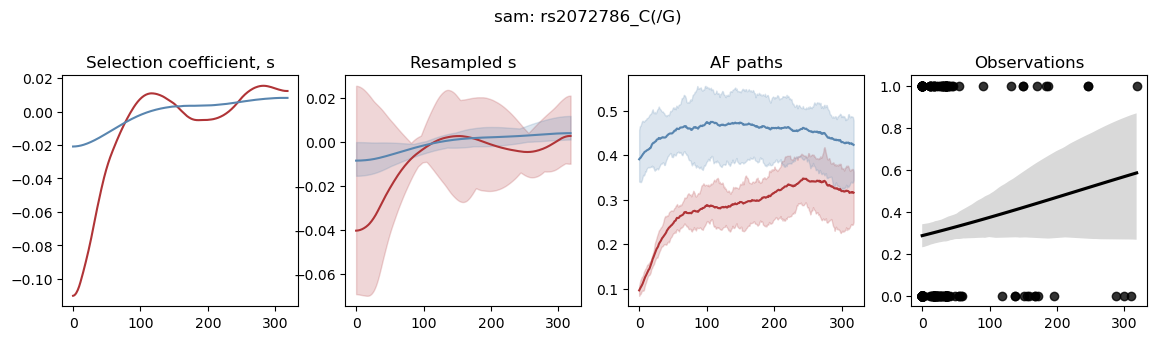

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=1,figsize=(14,3))
axs[0].plot(s[:, 0], color="#B03437", alpha=1)
axs[0].plot(s[:, 1], color="#5885AF", alpha=1)

high = np.max(s_samples,  axis=0)
low = np.min(s_samples,  axis=0)
axs[1].plot(np.mean(s_samples, axis=0)[0], color="#B03437")
axs[1].plot(np.mean(s_samples, axis=0)[1], color="#5885AF")

axs[1].fill_between(range(s_samples.shape[2]), low[0], high[0], alpha=0.2, color="#B03437")
axs[1].fill_between(range(s_samples.shape[2]), low[1], high[1], alpha=0.2, color="#5885AF")

high = np.max(paths,  axis=0)
low = np.min(paths,  axis=0)
axs[2].plot(np.mean(paths, axis=0)[0][::-1], color="#B03437")
axs[2].plot(np.mean(paths, axis=0)[1][::-1], color="#5885AF")
axs[2].fill_between(range(paths.shape[2]), low[0][::-1], high[0][::-1], alpha=0.2, color="#B03437")
axs[2].fill_between(range(paths.shape[2]), low[1][::-1], high[1][::-1], alpha=0.2, color="#5885AF")
a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
sns.regplot(x=a, y=b, logistic=True, ax=axs[3], color="black")

axs[0].set_title("Selection coefficient, s")
axs[1].set_title("Resampled s")
axs[2].set_title("AF paths")
axs[3].set_title("Observations")
fig.suptitle(pop+": "+snp, y=1.1)

In [16]:
#Run for rs174548 EAS 
pop="eas"
datasets, snps=read_data(pop)
snp="rs174548_C(/G)"
data=datasets[snps.index(snp)]

s,prior,Ne=run_analysis(data, alpha=1e4, beta=1, em_iterations=10)
#paths=sample_paths(s, Ne, data, prior, 100)
s_samples, paths=resample(s, data, Ne, prior, N=10)

2024-12-10 18:22:41.484 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.89549314, 1.0001    ],
       [5.9611829 , 4.56415074, 4.37417031]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(387.79971596, dtype=float64, weak_type=True), success=False, status=2, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(89, dtype=int32), num_jac_eval=Array(89, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:26:21.596 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.86923886e-02,  7.16389225e-02,  2.57782838e-02],
       [ 2.86708603e-02,  7.16220401e-02,  2.57738939e-02],
       [ 2.86577219e-02,  7.15937838e-02,  2.57700610e-02],
       [ 2.86272147e-02,  7.15442591e-02,  2.57591910e-02],
       [ 2.85813550e-02,  7.14882635e-02,  2.57507475e-02],
       [ 2.85369966e-02,  7.14082696e-02,  2.57322954e-02],
       [ 2.84767319e-02,  7.13256784e-02,  2.57169528e-02],
       [ 2.8412

2024-12-10 18:26:39.891 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.88126238, 1.0001    ],
       [5.96401361, 4.57216743, 4.37814457]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(355.42654879, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(72, dtype=int32), num_jac_eval=Array(72, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:30:32.520 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 7.26030239e-02,  7.48783471e-02,  4.85008090e-02],
       [ 7.25926764e-02,  7.48526421e-02,  4.84870477e-02],
       [ 7.26075689e-02,  7.47918806e-02,  4.84604269e-02],
       [ 7.25763701e-02,  7.47090800e-02,  4.84191474e-02],
       [ 7.25105243e-02,  7.45935454e-02,  4.83663039e-02],
       [ 7.24305457e-02,  7.44495421e-02,  4.82993186e-02],
       [ 7.22893848e-02,  7.42853190e-02,  4.82203930e-02],
       [ 7.2144

2024-12-10 18:30:38.847 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(353.08623904, dtype=float64, weak_type=True), success=True, status=0, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[[ 0.         -0.14591218  0.          0.01568139  0.06955237  0.02281697]], yk=[[-0.008489    0.00373289 -0.00333477  0.00088805  0.00982004  0.00076995]]), num_fun_eval=Array(24, dtype=int32), num_jac_eval=Array(24, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:33:13.685 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08840765e-02,  6.88556162e-02,  1.86028017e-02],
       [ 2.08904713e-02,  6.88506976e-02,  1.85980478e-02],
       [ 2.09086153e-02,  6.88409441e-02,  1.85884946e-02],
       [ 2.09289455e-02,  6.88262139e-02,  1.85740639e-02],
       [ 2.09643412e-02,  6.88063570e-02,  1.85546

2024-12-10 18:33:19.194 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11971562, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:35:36.290 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08839343e-02,  6.88559554e-02,  1.86028156e-02],
       [ 2.08903402e-02,  6.88510356e-02,  1.85980601e-02],
       [ 2.09084998e-02,  6.88412794e-02,  1.85885040e-02],
       [ 2.09288559e-02,  6.88265456e-02,  1.85740689e-02],
       [ 2.09642736e-02,  6.88066838e-02,  1.85546045e-02],
       [ 2.09962939e-02,  6.87812698e-02,  1.85300337e-02],
       [ 2.10409310e-02,  6.87501292e-02,  1.85001679e-02],
       [ 2.10715

2024-12-10 18:35:41.722 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11970875, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:38:14.350 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08841117e-02,  6.88556995e-02,  1.86028397e-02],
       [ 2.08905068e-02,  6.88507809e-02,  1.85980856e-02],
       [ 2.09086542e-02,  6.88410273e-02,  1.85885322e-02],
       [ 2.09289855e-02,  6.88262970e-02,  1.85741010e-02],
       [ 2.09643896e-02,  6.88064399e-02,  1.85546416e-02],
       [ 2.09963870e-02,  6.87810316e-02,  1.85300766e-02],
       [ 2.10406708e-02,  6.87498976e-02,  1.85002173e-02],
       [ 2.10716

2024-12-10 18:38:19.744 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11970933, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:40:52.311 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08841117e-02,  6.88556995e-02,  1.86028397e-02],
       [ 2.08905068e-02,  6.88507809e-02,  1.85980856e-02],
       [ 2.09086542e-02,  6.88410273e-02,  1.85885322e-02],
       [ 2.09289855e-02,  6.88262970e-02,  1.85741010e-02],
       [ 2.09643896e-02,  6.88064399e-02,  1.85546416e-02],
       [ 2.09963870e-02,  6.87810316e-02,  1.85300766e-02],
       [ 2.10406708e-02,  6.87498976e-02,  1.85002173e-02],
       [ 2.1071

2024-12-10 18:40:57.807 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11970933, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:43:30.114 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08841117e-02,  6.88556995e-02,  1.86028397e-02],
       [ 2.08905068e-02,  6.88507809e-02,  1.85980856e-02],
       [ 2.09086542e-02,  6.88410273e-02,  1.85885322e-02],
       [ 2.09289855e-02,  6.88262970e-02,  1.85741010e-02],
       [ 2.09643896e-02,  6.88064399e-02,  1.85546416e-02],
       [ 2.09963870e-02,  6.87810316e-02,  1.85300766e-02],
       [ 2.10406708e-02,  6.87498976e-02,  1.85002173e-02],
       [ 2.1071

2024-12-10 18:43:35.530 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11970933, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:46:08.205 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08841117e-02,  6.88556995e-02,  1.86028397e-02],
       [ 2.08905068e-02,  6.88507809e-02,  1.85980856e-02],
       [ 2.09086542e-02,  6.88410273e-02,  1.85885322e-02],
       [ 2.09289855e-02,  6.88262970e-02,  1.85741010e-02],
       [ 2.09643896e-02,  6.88064399e-02,  1.85546416e-02],
       [ 2.09963870e-02,  6.87810316e-02,  1.85300766e-02],
       [ 2.10406708e-02,  6.87498976e-02,  1.85002173e-02],
       [ 2.1071

2024-12-10 18:46:13.886 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11970933, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:48:46.634 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08841117e-02,  6.88556995e-02,  1.86028397e-02],
       [ 2.08905068e-02,  6.88507809e-02,  1.85980856e-02],
       [ 2.09086542e-02,  6.88410273e-02,  1.85885322e-02],
       [ 2.09289855e-02,  6.88262970e-02,  1.85741010e-02],
       [ 2.09643896e-02,  6.88064399e-02,  1.85546416e-02],
       [ 2.09963870e-02,  6.87810316e-02,  1.85300766e-02],
       [ 2.10406708e-02,  6.87498976e-02,  1.85002173e-02],
       [ 2.1071

2024-12-10 18:48:52.135 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.00010003, 1.73534978, 1.0001    ],
       [5.97969506, 4.64172004, 4.40096163]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(356.11970933, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:51:24.862 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.08841117e-02,  6.88556995e-02,  1.86028397e-02],
       [ 2.08905068e-02,  6.88507809e-02,  1.85980856e-02],
       [ 2.09086542e-02,  6.88410273e-02,  1.85885322e-02],
       [ 2.09289855e-02,  6.88262970e-02,  1.85741010e-02],
       [ 2.09643896e-02,  6.88064399e-02,  1.85546416e-02],
       [ 2.09963870e-02,  6.87810316e-02,  1.85300766e-02],
       [ 2.10406708e-02,  6.87498976e-02,  1.85002173e-02],
       [ 2.1071

2024-12-10 18:51:44.228 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  22.64626406,   1.0001    ],
       [100.        , 100.        ,  96.0596758 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(311.47804504, dtype=float64, weak_type=True), success=True, status=0, iter_num=17, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 1.88251870e+00 0.00000000e+00 1.61090046e+01
  1.23052221e+01 1.13544477e+01]
 [0.00000000e+00 2.40694557e+00 0.00000000e+00 1.96735779e+01
  1.49876757e+01 1.38679381e+01]
 [0.00000000e+00 3.86595556e+00 0.00000000e+00 2.37333668e+01
  2.31763052e+01 2.15268420e+01]
 [0.00000000e+00 2.52258599e+00 0.00000000e+00 0.00000000e+00
  4.95558720e+00 5.18921708e+00]
 [0.00000000e+00 3.51612307e+00 0.00000000e+00 0.00000000e+00
  7.23460188e+00 7.60145532e+00]
 [0.00000000e+00 3.24879675e+00 0.00000000e+00 0.00000000e+00
  6.38687000e+00 7.90355677e+00]
 [0.00000000e+00 1.63782094e-02 0.00000000e+00 6.66994513e-01
  5.28

2024-12-10 18:53:54.635 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  22.64626406,   1.0001    ],
       [100.        , 100.        ,  96.0596758 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(295.30087344, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:55:58.052 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.06167469e-02,  4.83703494e-02, -8.17551352e-03],
       [ 1.06172513e-02,  4.83671950e-02, -8.18499501e-03],
       [ 1.06182241e-02,  4.83610827e-02, -8.20308770e-03],
       [ 1.06195949e-02,  4.83522505e-02, -8.22788785e-03],
       [ 1.06213098e-02,  4.83409665e-02, -8.25798809e-03],
       [ 1.06233279e-02,  4.83275206e-02, -8.29232728e-03],
       [ 1.06255697e-02,  4.83122058e-02, -8.32872043e-03],
   

2024-12-10 18:56:22.631 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  38.50127235,   2.37547364],
       [100.        ,  29.82025587,  55.16206565]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(314.2787191, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(69, dtype=int32), num_jac_eval=Array(69, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 18:58:32.364 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 6.67714595e-03,  1.78137129e-02, -1.75021136e-02],
       [ 6.67644907e-03,  1.78130196e-02, -1.75011237e-02],
       [ 6.67501944e-03,  1.78118864e-02, -1.74995395e-02],
       [ 6.67287427e-03,  1.78105309e-02, -1.74976550e-02],
       [ 6.67025827e-03,  1.78090986e-02, -1.74956448e-02],
       [ 6.66705223e-03,  1.78076563e-02, -1.74936063e-02],
       [ 6.66365984e-03,  1.78062277e-02, -1.74915810e-02],
    

2024-12-10 18:59:07.086 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  23.47060956,  11.45181388],
       [100.        ,  42.34340614,  54.70339579]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(306.46736622, dtype=float64, weak_type=True), success=True, status=0, iter_num=11, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(105, dtype=int32), num_jac_eval=Array(105, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:03:11.091 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.16339938e-02,  7.37212733e-02, -6.12446625e-02],
       [ 1.16307801e-02,  7.36939889e-02, -6.12225083e-02],
       [ 1.16254082e-02,  7.36399195e-02, -6.11792792e-02],
       [ 1.16159791e-02,  7.35593593e-02, -6.11160396e-02],
       [ 1.16044395e-02,  7.34527017e-02, -6.10337958e-02],
       [ 1.15887981e-02,  7.33202576e-02, -6.09335503e-02],
       [ 1.15701173e-02,  7.31622228e-02, -6.08162405e-02],
 

2024-12-10 19:03:30.711 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  41.41893665,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(298.0953226, dtype=float64, weak_type=True), success=False, status=2, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(55, dtype=int32), num_jac_eval=Array(55, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:06:52.690 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 5.75066890e-03,  6.66361464e-02, -7.62214212e-02],
       [ 5.75019211e-03,  6.66170135e-02, -7.61847277e-02],
       [ 5.74886260e-03,  6.65790909e-02, -7.61131948e-02],
       [ 5.74690957e-03,  6.65227163e-02, -7.60101375e-02],
       [ 5.74366054e-03,  6.64483308e-02, -7.58771399e-02],
       [ 5.73966949e-03,  6.63564417e-02, -7.57166768e-02],
       [ 5.73450498e-03,  6.62475646e-02, -7.55272411e-02],
   

2024-12-10 19:07:25.232 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  41.12600137,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(285.3148274, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[ 0.         -0.00062003  0.          0.          0.          0.        ]], yk=[[-8.32991019e-09 -4.28650315e-08 -7.76587599e-09  1.56245382e-10
   1.35234036e-07  1.55685614e-10]]), num_fun_eval=Array(99, dtype=int32), num_jac_eval=Array(99, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:11:33.292 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 5.99208412e-03,  6.70430651e-02, -7.70841770e-02],
       [ 5.99245150e-03,  6.70230633e-02, -7.70461170e-02],
       [ 5.99315110e-03,  6.69835062e-02, -7.69702052e-02],
       [ 5.99397938e-03,  6.69245955e-02, -7.68612750e-02],
       [ 5.99

2024-12-10 19:11:52.928 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  20.47842452,   1.0001    ],
       [100.        ,  79.7764749 ,  73.96168182]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(323.73481772, dtype=float64, weak_type=True), success=True, status=0, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  1.28597300e+00  0.00000000e+00  1.03732125e+01
   7.84350106e+00  7.07877742e+00]
 [ 0.00000000e+00  1.39827381e+00  0.00000000e+00  1.07180271e+01
   8.07419824e+00  7.33431770e+00]
 [ 0.00000000e+00  2.40930669e+00  0.00000000e+00  1.64200857e+01
   1.22731751e+01  1.12578155e+01]
 [ 0.00000000e+00  2.95087046e+00  0.00000000e+00  1.91729800e+01
   1.42977976e+01  1.31506566e+01]
 [ 0.00000000e+00  4.22893992e+00  0.00000000e+00  2.43437408e+01
   2.00914826e+01  1.84998420e+01]
 [ 0.00000000e+00  7.18249574e-01  0.00000000e+00  0.00000000e+00
   2.87731546e-01  3.55299348e-01]
 [ 0.00000000e+00  1.86041946e+0

2024-12-10 19:14:39.915 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  19.66006204,   1.0001    ],
       [100.        ,  80.03071653,  73.98998205]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(305.20078845, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(135, dtype=int32), num_jac_eval=Array(135, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:18:14.046 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 9.10075193e-03,  5.25406980e-02,  4.96904422e-03],
       [ 9.10075284e-03,  5.25375144e-02,  4.97261102e-03],
       [ 9.10079085e-03,  5.25312918e-02,  4.97955606e-03],
       [ 9.10090994e-03,  5.25221832e-02,  4.98970110e-03],
       [ 9.10114231e-03,  5.25103479e-02,  5.00287690e-03],
       [ 9.10151826e-03,  5.24959455e-02,  5.01892205e-03],
       [ 9.10207804e-03,  5.24791447e-02,  5.03768232e-03],
  

2024-12-10 19:18:41.442 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    ,  4.29489626, 11.66757626],
       [42.44555372, 32.36745421, 27.5638188 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(403.70292092, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 3.39020654e-03 5.68199999e-02 2.09055086e-01
  1.60714199e-01 1.38582208e-01]
 [0.00000000e+00 1.91011677e-02 1.14985355e-01 4.75411035e-01
  3.56562213e-01 3.22341206e-01]
 [0.00000000e+00 5.23930331e-05 2.68209750e-04 1.11319955e-03
  8.31828136e-04 7.56065875e-04]
 [0.00000000e+00 0.00000000e+00 3.72741138e-01 1.59738412e+00
  1.24495827e+00 9.98020473e-01]
 [0.00000000e+00 0.00000000e+00 6.90498338e-01 2.32662111e+00
  1.80607053e+00 1.43957687e+00]
 [0.00000000e+00 0.00000000e+00 4.10186990e-02 1.59747803e-01
  1.24081035e-01 1.02612032e-01]
 [0.00000000e+00 0.00000000e+00 2.38296558e-03 1.12466529e-02
  8.77383844

2024-12-10 19:22:14.205 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    ,  5.24564687, 12.22586205],
       [42.53246377, 32.65967067, 27.37069415]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(378.85702171, dtype=float64, weak_type=True), success=True, status=0, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[[ 0.         -0.00764533  0.00224744  0.0004337   0.00244612 -0.00077292]], yk=[[ 6.40242972e-06 -6.29154996e-04 -8.47287511e-05 -1.16294673e-07
   5.43777193e-05  4.33629502e-05]]), num_fun_eval=Array(119, dtype=int32), num_jac_eval=Array(119, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:24:50.667 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.31192303e-02,  5.01115954e-02,  5.79304158e-02],
       [ 1.31445854e-02,  5.01096625e-02,  5.79100581e-02],
       [ 1.31699800e-02,  5.01058771e-02,  5.78682896e-02],
       [ 1.31848654e-02,  5.01002970e-02,  5.78029907e-02],
       [ 1.31893

2024-12-10 19:25:17.343 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 13.96271396,  50.03217116,   1.0001    ],
       [100.        ,  71.24211661, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(308.78600801, dtype=float64, weak_type=True), success=True, status=0, iter_num=22, hess_inv=LbfgsInvHessProduct(sk=[[ 1.81809224e+00  6.71780102e+00  0.00000000e+00  1.46080703e+01
   1.02598992e+01  1.60084999e+01]
 [ 2.85208039e+00  1.07137710e+01  0.00000000e+00  2.29360470e+01
   1.60149431e+01  2.51274902e+01]
 [ 2.71597120e+00  1.02205293e+01  0.00000000e+00  2.08569712e+01
   1.52132009e+01  1.39416841e+01]
 [ 1.97345175e-02  4.13041947e-01  0.00000000e+00  0.00000000e+00
  -6.68869244e-02  0.00000000e+00]
 [ 9.35205783e-01  2.40217400e+00  0.00000000e+00  0.00000000e+00
   1.76142992e-01  0.00000000e+00]
 [-2.07679817e-01  9.14672896e-01  0.00000000e+00  0.00000000e+00
   1.32409311e-01  0.00000000e+00]
 [-1.46168950e-03  9.06876885e-0

2024-12-10 19:30:31.121 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 13.198484  ,  49.44252884,   1.0001    ],
       [100.        ,  71.62306839, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(293.66264965, dtype=float64, weak_type=True), success=True, status=0, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[[-0.02809803 -0.02694996  0.          0.          0.01870327  0.        ]
 [-0.00014017 -0.00028597  0.          0.          0.00018165  0.        ]], yk=[[-1.39479882e-04 -1.64243126e-06 -1.53361347e-06  1.99632811e-05
   1.58004005e-05  3.05079768e-08]
 [-2.33803551e-07 -1.88987141e-07 -1.26191136e-08  4.52775359e-08
   1.53127268e-07  2.49949159e-10]]), num_fun_eval=Array(99, dtype=int32), num_jac_eval=Array(99, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:33:25.396 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.89512199e-02,  7.23175919e-02, -6.92384244e-02],
       [ 3.89538

2024-12-10 19:33:53.185 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 38.32219791,  63.84973777,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(318.85440565, dtype=float64, weak_type=True), success=True, status=0, iter_num=18, hess_inv=LbfgsInvHessProduct(sk=[[-0.00029276 -0.00022234  0.          0.          0.          0.        ]], yk=[[-1.34486981e-07 -2.53384834e-08 -1.63860500e-08  8.45359988e-08
   4.81500250e-08  2.93293451e-10]]), num_fun_eval=Array(78, dtype=int32), num_jac_eval=Array(78, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:36:59.905 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.08891230e-02,  5.93599830e-02, -5.68911227e-02],
       [ 3.08892744e-02,  5.93552782e-02, -5.68639134e-02],
       [ 3.08895585e-02,  5.93461573e-02, -5.68112123e-02],
       [ 3.08899497e-02,  5.93328886e-02, -5.67348373e-02],
       [ 3.

2024-12-10 19:37:19.482 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 38.85581109,  61.47212513,   1.0001    ],
       [ 99.82329247, 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(302.36140067, dtype=float64, weak_type=True), success=True, status=0, iter_num=7, hess_inv=LbfgsInvHessProduct(sk=[[ 2.37017155e-03 -1.67207839e-02  0.00000000e+00 -8.03411320e-04
   0.00000000e+00  0.00000000e+00]
 [ 2.80591648e-04 -1.31096531e-03  0.00000000e+00 -9.30754125e-05
   0.00000000e+00  0.00000000e+00]
 [ 1.22517809e-05 -5.61351872e-05  0.00000000e+00 -3.48763449e-06
   0.00000000e+00  0.00000000e+00]], yk=[[ 4.99747323e-07 -2.81506612e-05 -2.48979716e-07 -2.47328702e-07
   2.05687593e-05  4.82390910e-09]
 [ 7.29701451e-08 -6.02251235e-07 -1.90760111e-08 -3.49230932e-08
   4.79048091e-07  3.73998944e-10]
 [ 3.12825020e-09 -9.03961812e-10 -8.16083838e-10 -1.49725644e-09
   8.65281342e-09  1.60016840e-11]]), num_fun_eval=Array(58, dt

2024-12-10 19:40:52.258 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  9.08955015,  37.82178736,   1.0001    ],
       [100.        ,  89.23236756, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(312.40082216, dtype=float64, weak_type=True), success=True, status=0, iter_num=23, hess_inv=LbfgsInvHessProduct(sk=[[-8.67673708e-01  2.93258457e-01  0.00000000e+00  0.00000000e+00
   2.74069443e+00  0.00000000e+00]
 [-9.43001112e-03  8.33302479e-02  0.00000000e+00  0.00000000e+00
   2.31803280e-01  0.00000000e+00]
 [ 8.61168179e-01  3.39726805e+00  0.00000000e+00  1.07838434e+01
   7.38056869e+00  1.00976859e+01]
 [ 7.28999352e-02  2.85757962e-01  0.00000000e+00  9.20136450e-01
   6.32019786e-01  8.61600241e-01]
 [ 2.11780764e-01  8.25433792e-01  0.00000000e+00  2.69879741e+00
   1.85885578e+00  2.52545237e+00]
 [ 1.95697862e-01  8.23809915e-01  0.00000000e+00  2.15434962e+00
   1.88015877e+00  2.42275174e+00]
 [ 1.85364465e-03  7.18586051e-0

2024-12-10 19:44:35.390 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  9.08946285,  37.82121096,   1.0001    ],
       [100.        ,  89.2326297 , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(297.2024334, dtype=float64, weak_type=True), success=True, status=0, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(58, dtype=int32), num_jac_eval=Array(58, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:46:49.601 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.79831579e-02,  7.08567150e-02, -2.30824133e-02],
       [ 3.79827172e-02,  7.08535631e-02, -2.30905847e-02],
       [ 3.79817664e-02,  7.08473805e-02, -2.31076567e-02],
       [ 3.79802969e-02,  7.08381598e-02, -2.31316122e-02],
       [ 3.79781762e-02,  7.08257628e-02, -2.31700348e-02],
       [ 3.79752617e-02,  7.08097234e-02, -2.32141290e-02],
       [ 3.79714143e-02,  7.07895251e-02, -2.32642620e-02],
     

2024-12-10 19:47:30.460 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  39.86757577,   1.0001    ],
       [100.        ,  88.15786342, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(301.82848847, dtype=float64, weak_type=True), success=True, status=0, iter_num=22, hess_inv=LbfgsInvHessProduct(sk=[[ 0.         -0.00163469  0.          0.          0.00097206  0.        ]], yk=[[-5.41708533e-08 -9.93665081e-06 -1.99300111e-07  1.12966992e-09
   4.56333182e-06  3.61046132e-09]]), num_fun_eval=Array(119, dtype=int32), num_jac_eval=Array(119, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:50:27.807 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 9.98983803e-03,  5.25727678e-02, -4.11571983e-02],
       [ 9.98972564e-03,  5.25643638e-02, -4.11420329e-02],
       [ 9.98948853e-03,  5.25478783e-02, -4.11124340e-02],
       [ 9.98919758e-03,  5.25236343e-02, -4.10691964e-02],
       [ 

2024-12-10 19:50:56.299 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  38.73048184,   1.0001    ],
       [100.        ,  88.70967811, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(285.0719294, dtype=float64, weak_type=True), success=False, status=2, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(84, dtype=int32), num_jac_eval=Array(84, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 19:53:26.626 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 9.93820675e-03,  5.28490112e-02, -4.13921178e-02],
       [ 9.93821404e-03,  5.28401685e-02, -4.13763339e-02],
       [ 9.93822779e-03,  5.28228099e-02, -4.13455595e-02],
       [ 9.93825739e-03,  5.27972883e-02, -4.13006198e-02],
       [ 9.93828676e-03,  5.27639898e-02, -4.12423612e-02],
       [ 9.93830893e-03,  5.27233798e-02, -4.11716553e-02],
       [ 9.93829821e-03,  5.26759073e-02, -4.10893882e-02],
    

2024-12-10 19:53:38.396 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  40.99503599,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(296.95680415, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[[ 0.          5.76808052  0.         20.81466256 14.8152077  16.60170859]
 [ 0.          6.41607335  0.         23.15634837 16.48528369 18.46787242]
 [ 0.          8.62490318  0.          8.09998605 21.76903535 24.42682314]
 [ 0.          7.52848729  0.          0.         12.49997927  2.55760003]
 [ 0.          0.51595366  0.          2.49751549  1.79555032  1.91740928]
 [ 0.          0.87565065  0.          3.50695565  2.50337574  2.75726564]
 [ 0.          1.17447259  0.          4.82271117  3.47258695  3.80905941]
 [ 0.          1.87659431  0.          7.43722737  5.35226769  5.90248348]
 [ 0.          2.80538154  0.         

2024-12-10 19:57:24.843 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  40.82157181,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(283.83755396, dtype=float64, weak_type=True), success=True, status=0, iter_num=7, hess_inv=LbfgsInvHessProduct(sk=[[ 0.         -0.00064949  0.          0.          0.          0.        ]], yk=[[-2.49650206e-08 -2.62822760e-07 -2.97136370e-08  4.85507197e-10
   1.82219271e-07  5.60022913e-10]]), num_fun_eval=Array(71, dtype=int32), num_jac_eval=Array(71, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-12-10 20:01:03.249 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.24932877e-02,  4.57087850e-02, -6.42697592e-02],
       [ 1.24917293e-02,  4.57038370e-02, -6.42483257e-02],
       [ 1.24901612e-02,  4.56955783e-02, -6.41988601e-02],
       [ 1.24856994e-02,  4.56820536e-02, -6.41362928e-02],
       [ 1.2

Text(0.5, 1.1, 'eas: rs174548_C(/G)')

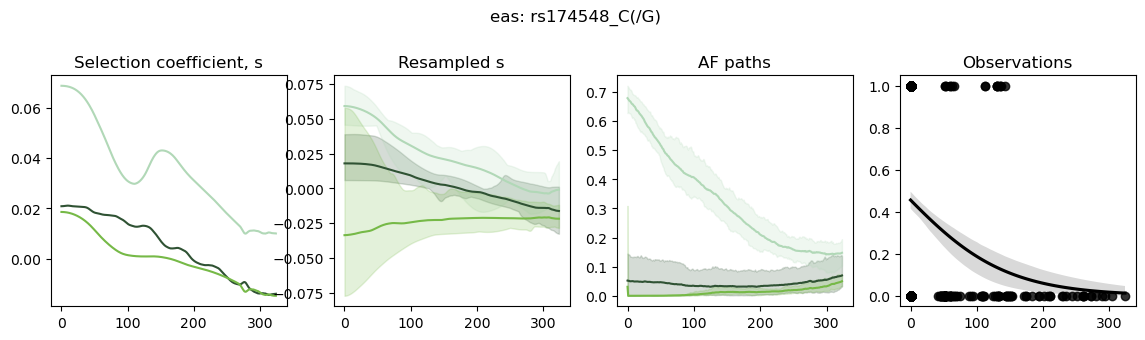

In [17]:
fig, axs = plt.subplots(ncols=4, nrows=1,figsize=(14,3))
axs[0].plot(s[:, 0], color="#2F5233", alpha=1)
axs[0].plot(s[:, 1], color="#B1D8B7", alpha=1)
axs[0].plot(s[:, 2], color="#76B947", alpha=1)

high = np.max(s_samples,  axis=0)
low = np.min(s_samples,  axis=0)
axs[1].plot(np.mean(s_samples, axis=0)[0], color="#2F5233")
axs[1].plot(np.mean(s_samples, axis=0)[1], color="#B1D8B7")
axs[1].plot(np.mean(s_samples, axis=0)[2], color="#76B947")

axs[1].fill_between(range(s_samples.shape[2]), low[0], high[0], alpha=0.2, color="#2F5233")
axs[1].fill_between(range(s_samples.shape[2]), low[1], high[1], alpha=0.2, color="#B1D8B7")
axs[1].fill_between(range(s_samples.shape[2]), low[2], high[2], alpha=0.2, color="#76B947")

high = np.max(paths,  axis=0)
low = np.min(paths,  axis=0)
axs[2].plot(np.mean(paths, axis=0)[0][::-1], color="#2F5233")
axs[2].plot(np.mean(paths, axis=0)[1][::-1], color="#B1D8B7")
axs[2].plot(np.mean(paths, axis=0)[2][::-1], color="#76B947")
axs[2].fill_between(range(paths.shape[2]), low[0][::-1], high[0][::-1], alpha=0.2, color="#2F5233")
axs[2].fill_between(range(paths.shape[2]), low[1][::-1], high[1][::-1], alpha=0.2, color="#B1D8B7")
axs[2].fill_between(range(paths.shape[2]), low[2][::-1], high[2][::-1], alpha=0.2, color="#76B947")
a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
sns.regplot(x=a, y=b, logistic=True, ax=axs[3], color="black")

axs[0].set_title("Selection coefficient, s")
axs[1].set_title("Resampled s")
axs[2].set_title("AF paths")
axs[3].set_title("Observations")
fig.suptitle(pop+": "+snp, y=1.1)
